# Predicting House Prices in Tehran, Iran

Dataset: https://www.kaggle.com/datasets/mokar2001/house-price-tehran-iran/data

In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
import seaborn as sns
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load 

In [43]:
df1 = pd.read_csv("housePrice.csv")
df1.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [44]:
df1.shape

(3479, 8)

# Data Cleaning

In [45]:
df1.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [46]:
df1 = df1.drop(['Price'], axis='columns')

In [47]:
df1 = df1.dropna(subset=['Address','Area'])

In [48]:
df1.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price(USD)    0
dtype: int64

# Feature Engineering

In [49]:
df1[['Parking', 'Warehouse', 'Elevator']] = df1[['Parking', 'Warehouse', 'Elevator']].astype(int)

In [50]:
df1 = df1[df1["Room"] != 0]

In [51]:
df1.Address = df1.Address.apply(lambda x: x.strip())

location_stats = df1.groupby('Address')['Address'].agg('count').sort_values(ascending=False)
location_stats

Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                141
Shahran                   130
                         ... 
Telecommunication           1
Villa                       1
Varamin - Beheshti          1
Yakhchiabad                 1
Zibadasht                   1
Name: Address, Length: 192, dtype: int64

In [52]:
len(location_stats[location_stats<=10])

128

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [53]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Address
Ozgol                 10
Gholhak               10
Air force             10
Zafar                 10
Araj                   9
                      ..
Telecommunication      1
Villa                  1
Varamin - Beheshti     1
Yakhchiabad            1
Zibadasht              1
Name: Address, Length: 128, dtype: int64

In [54]:
df1.Address = df1.Address.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df1["Address"].unique())

65

Add new feature called price per square feet

In [55]:
df1['Price(USD)'] = pd.to_numeric(df1['Price(USD)'], errors='coerce')
df1['Area'] = pd.to_numeric(df1['Area'], errors='coerce')

df1['Price_per_sqft'] = df1['Price(USD)']/(df1['Area'])
df1.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Price_per_sqft
0,63.0,1,1,1,1,Shahran,61666.67,978.836032
1,60.0,1,1,1,1,Shahran,61666.67,1027.777833
2,79.0,2,1,1,1,Pardis,18333.33,232.067468
3,95.0,2,1,1,1,Shahrake Qods,30083.33,316.666632
4,123.0,2,1,1,1,Shahrake Gharb,233333.33,1897.018943


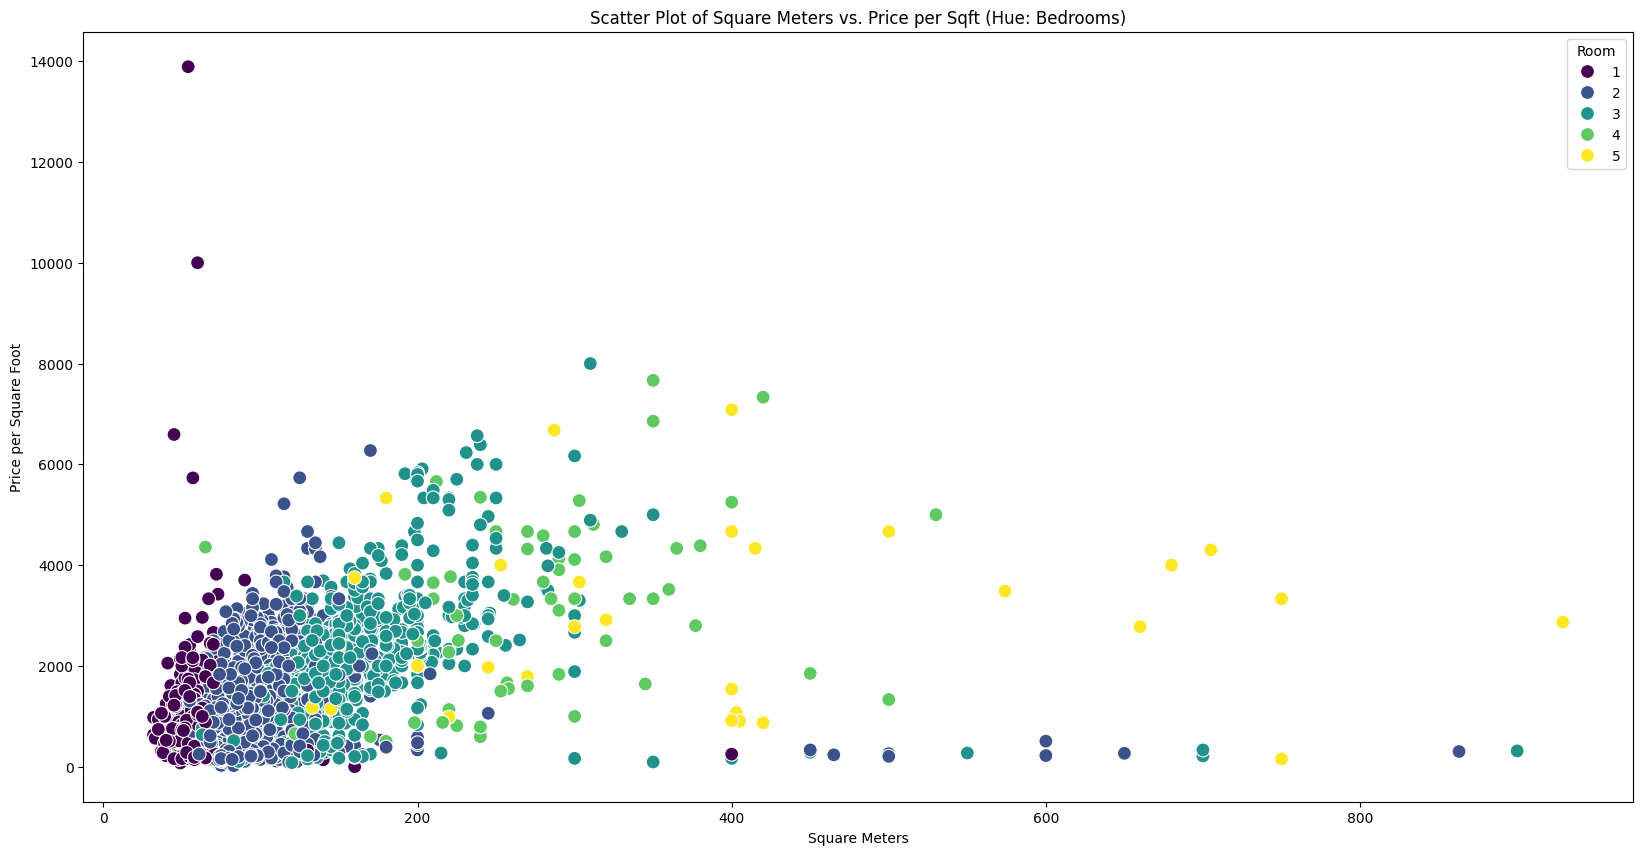

In [56]:
sns.scatterplot(
    x=df1["Area"],
    y=df1["Price_per_sqft"],
    hue=df1["Room"],
    palette="viridis",
    s=100
)

plt.xlabel("Square Meters")
plt.ylabel("Price per Square Foot")
plt.title("Scatter Plot of Square Meters vs. Price per Sqft (Hue: Bedrooms)")
plt.show()

## Outlier Removal

In [57]:
df1[df1.Area/df1.Room<30].head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Price_per_sqft
8,54.0,2,1,1,0,Andisheh,16433.33,304.320926
73,88.0,3,0,0,1,Parand,18666.67,212.121250
79,88.0,3,0,0,1,Parand,18666.67,212.121250
213,58.0,2,1,1,1,Shahran,73333.33,1264.367759
310,59.0,2,1,1,1,Southern Janatabad,63333.33,1073.446271


In [58]:
df2 = df1[~(df1.Area/df1.Room<=40)]
df2 = df2[~((df2["Area"]>600) & (df2["Room"]<4))]
df2 = df2[~((df2["Area"]<100) & (df2["Room"]>3))]
df2 = df2[~((df2["Area"]>380) & (df2["Room"]<=3))]
df2 = df2[~((df2["Price_per_sqft"]<1000) & (df2["Room"]>=4))]
df2 = df2[~((df2["Price_per_sqft"]>5000) & (df2["Room"]==1))]

df2.shape

(2569, 8)

In [59]:
df2.Price_per_sqft.describe()

count    2563.000000
mean     1510.845645
std      1097.477938
min         0.750000
25%       718.451541
50%      1289.215735
75%      2054.771033
max      8000.000000
Name: Price_per_sqft, dtype: float64

In [60]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Address'):
        m = np.mean(subdf.Price_per_sqft)
        st = np.std(subdf.Price_per_sqft)
        reduced_df = subdf[(subdf.Price_per_sqft>(m-st))&(subdf.Price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df3 = remove_pps_outliers(df2)
df3.shape

(1897, 8)

In [61]:
# Define reasonable thresholds for area and price
max_area = 800  # Example threshold for area in square meters
max_price = 6000  # Example threshold for price (in USD)

# Filter out rows where area or price is too large
df3 = df2[(df2["Area"] <= max_area) & (df2["Price_per_sqft"] <= max_price)]


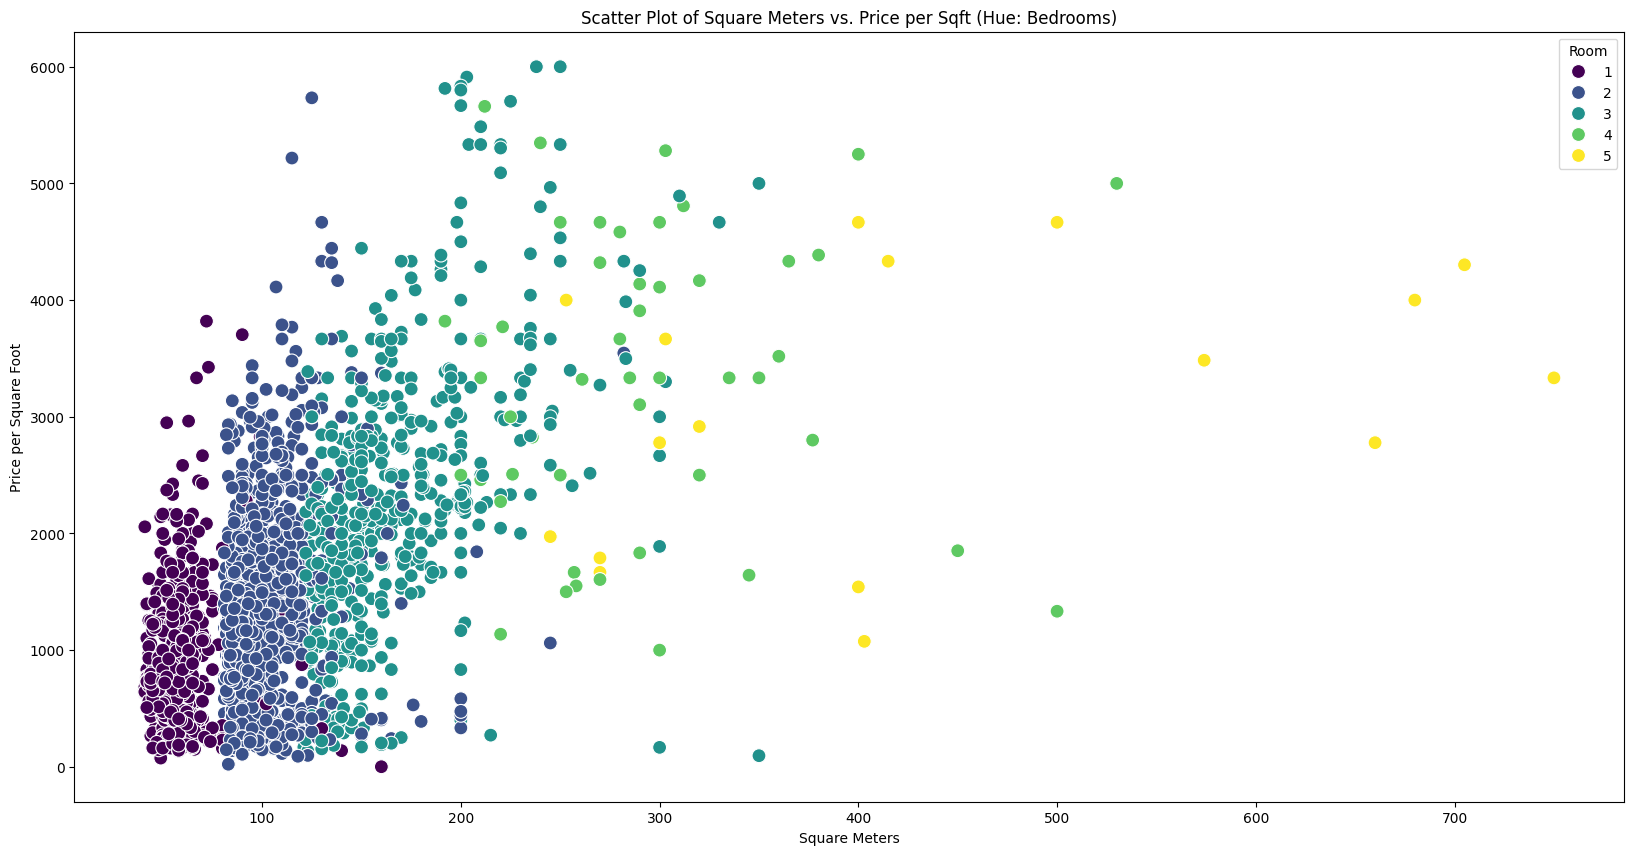

In [62]:
sns.scatterplot(
    x=df3["Area"],
    y=df3["Price_per_sqft"],
    hue=df3["Room"],
    palette="viridis",
    s=100
)

# Adding labels and title
plt.xlabel("Square Meters")
plt.ylabel("Price per Square Foot")
plt.title("Scatter Plot of Square Meters vs. Price per Sqft (Hue: Bedrooms)")
plt.show()

In [63]:
high_price_addresses = df2[df2["Price_per_sqft"] > 9000]["Address"]
print(high_price_addresses)

Series([], Name: Address, dtype: object)


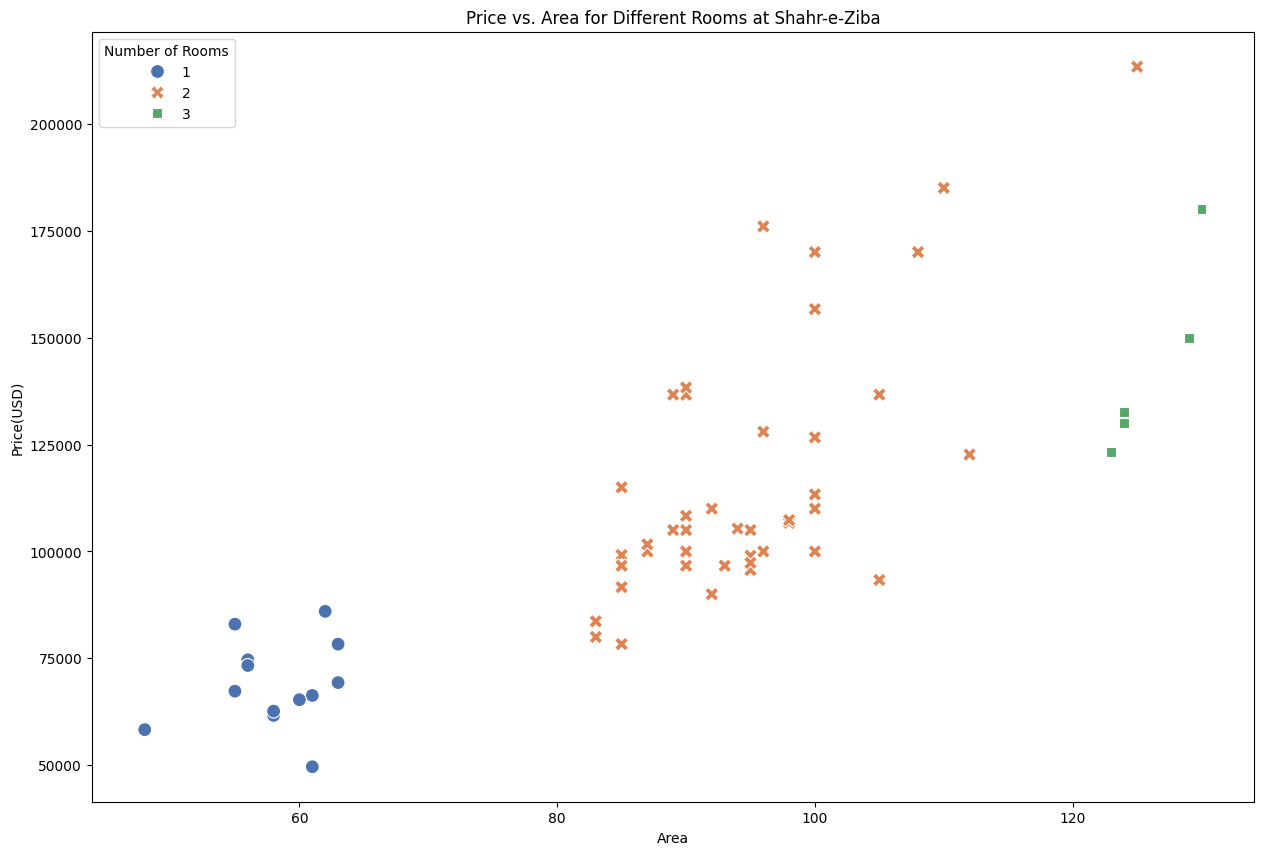

In [64]:
import seaborn as sns

def plot_scatter_chart(df2, Address):
    room_data = df2[df2.Address == Address]
   
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    
    sns.scatterplot(data=room_data, x="Area", y="Price(USD)", hue="Room", style="Room", palette="deep", s=100)
    
    plt.xlabel("Area")
    plt.ylabel("Price(USD)")
    plt.title(f"Price vs. Area for Different Rooms at {Address}")
    plt.legend(title='Number of Rooms')
   
    plt.show()

plot_scatter_chart(df3, "Shahr-e-Ziba")


We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). 

In [65]:
def remove_room_outliers(df):
    exclude_indices = np.array([])
    for Address, Address_df in df.groupby('Address'):
        room_stats = {}
        for room, room_df in Address_df.groupby('Room'):
            room_stats[room] = {
                'mean': np.mean(room_df.Price_per_sqft),
                'std': np.std(room_df.Price_per_sqft),
                'count': room_df.shape[0]
            }
        for room, room_df in Address_df.groupby('Room'):
            stats = room_stats.get(room-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, room_df[room_df.Price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df4 = remove_room_outliers(df3)
df4.shape

(2069, 8)

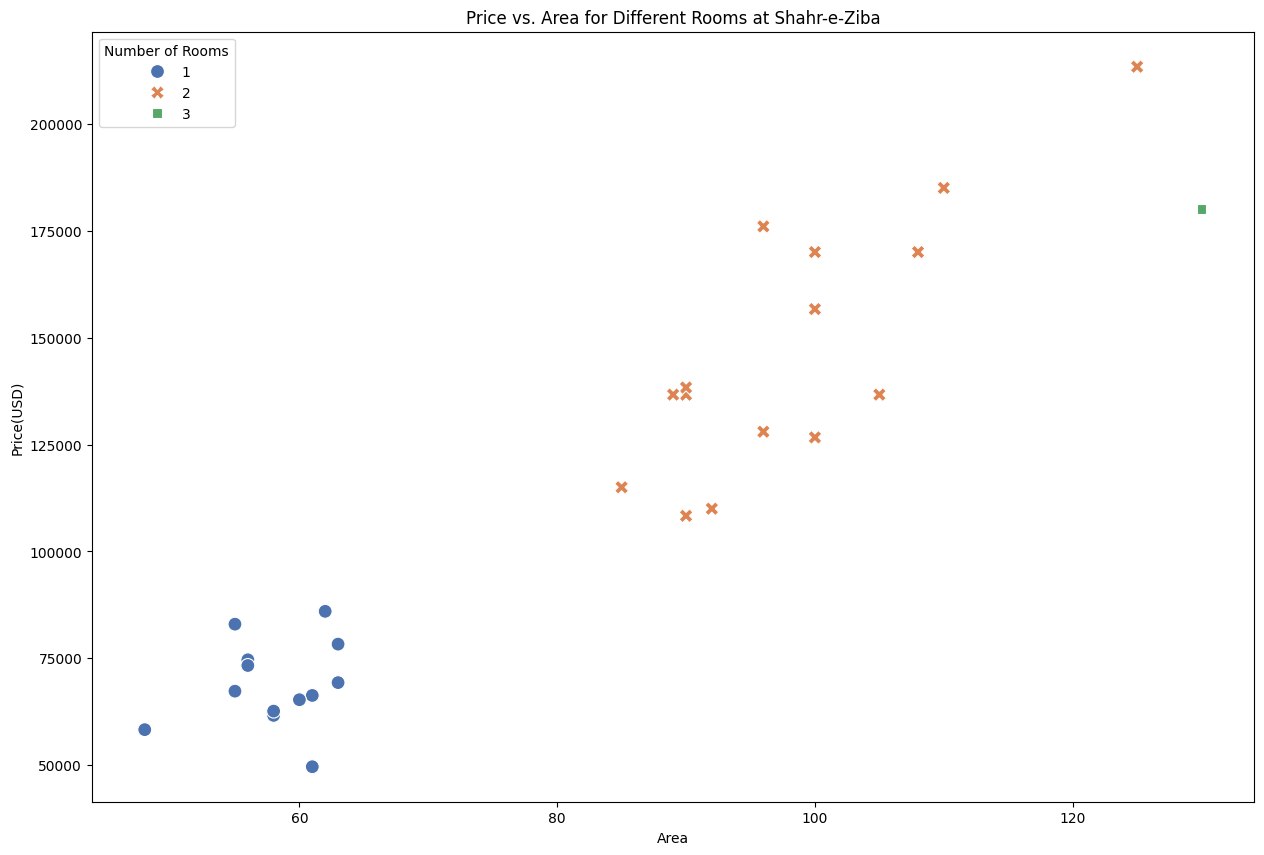

In [66]:
import seaborn as sns

def plot_scatter_chart(df2, Address):
    room_data = df2[df2.Address == Address]

    matplotlib.rcParams['figure.figsize'] = (15, 10)

    sns.scatterplot(data=room_data, x="Area", y="Price(USD)", hue="Room", style="Room", palette="deep", s=100)

    plt.xlabel("Area")
    plt.ylabel("Price(USD)")
    plt.title(f"Price vs. Area for Different Rooms at {Address}")
    plt.legend(title='Number of Rooms')
  
    plt.show()

plot_scatter_chart(df4, "Shahr-e-Ziba")


Text(0, 0.5, 'Count')

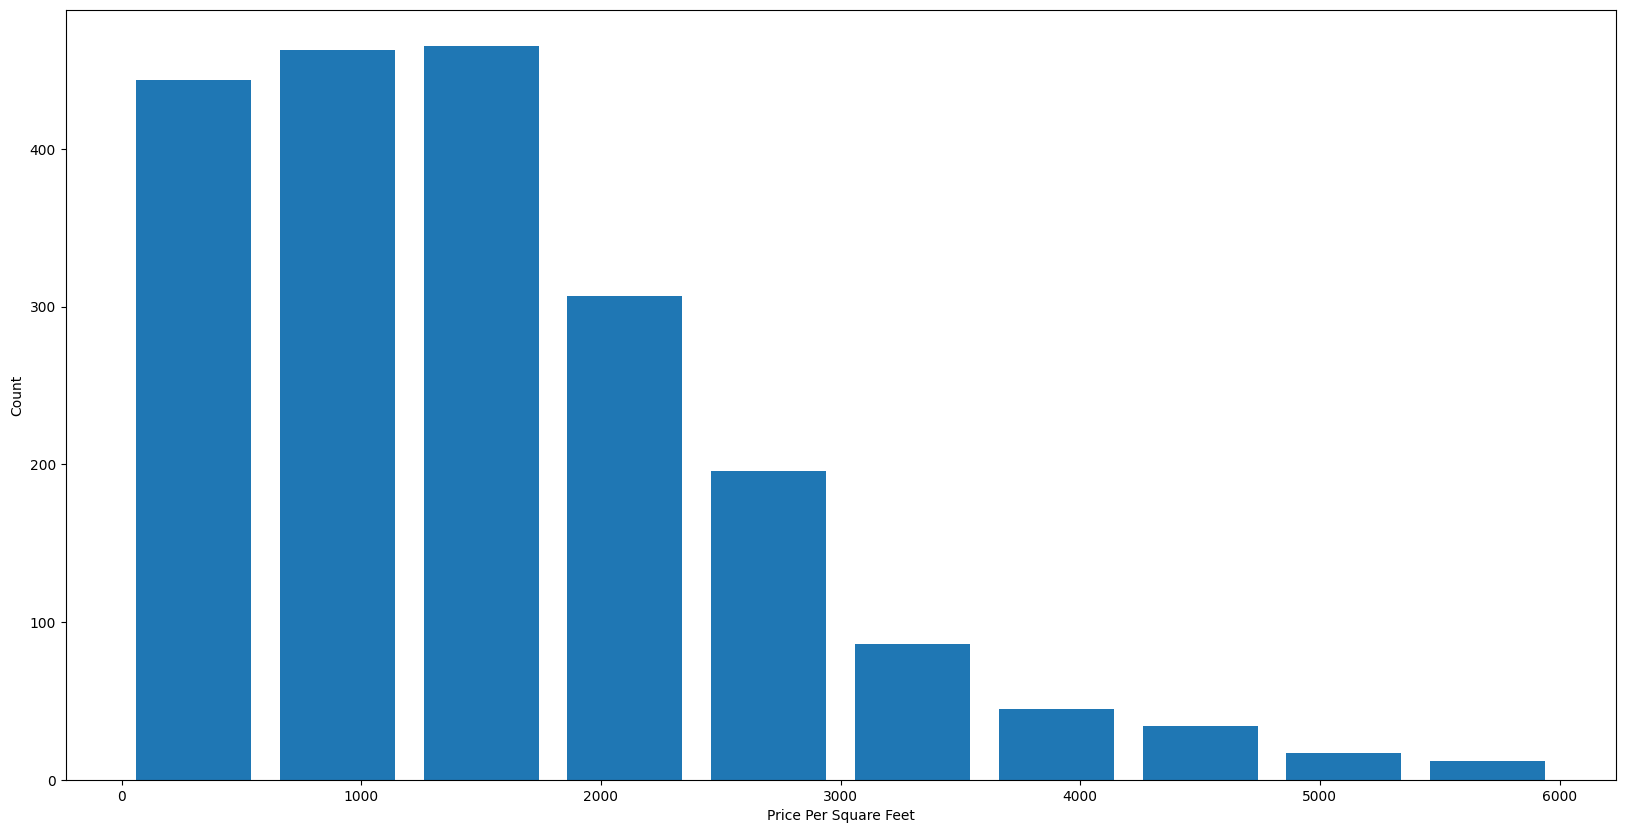

In [67]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df4.Price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

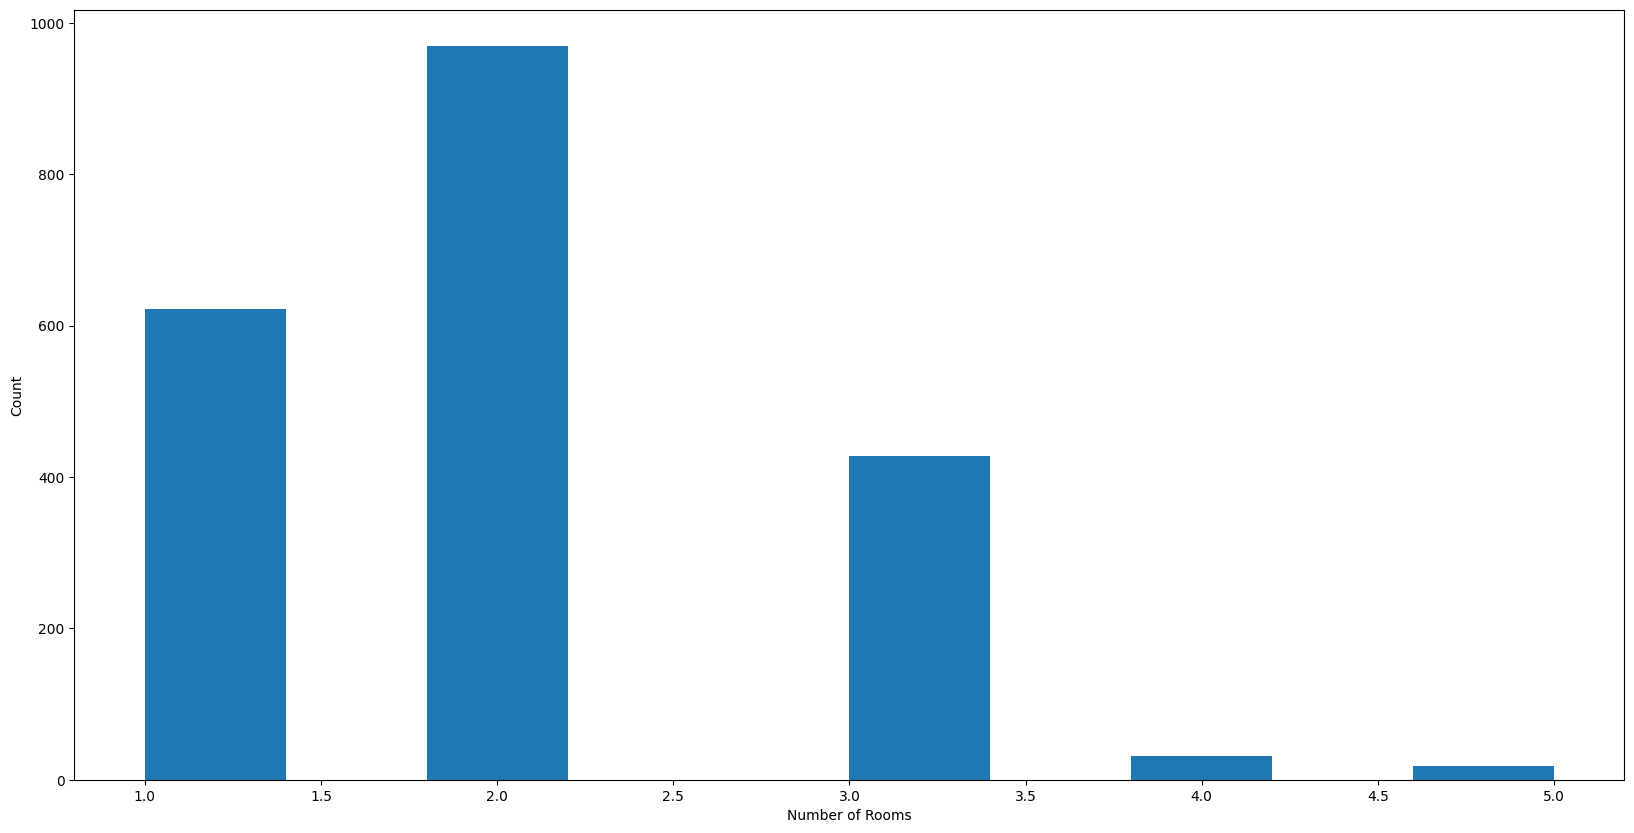

In [68]:
plt.hist(df4.Room,rwidth=1)
plt.xlabel("Number of Rooms")
plt.ylabel("Count")

In [69]:
df5 = df4.drop(["Price_per_sqft"], axis='columns')
df5.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD)
0,63.0,1,1,1,1,Shahran,61666.67
1,60.0,1,1,1,1,Shahran,61666.67
3,95.0,2,1,1,1,Shahrake Qods,30083.33
4,123.0,2,1,1,1,Shahrake Gharb,233333.33
6,87.0,2,1,1,1,Pardis,20000.00


Use One Hot Encoding For Location

In [70]:
address_dummies = pd.get_dummies(df5.Address)
print(address_dummies.dtypes)

address_dummies = address_dummies.astype(int)
address_dummies.head()

Abazar                    bool
Amirabad                  bool
Amirieh                   bool
Andisheh                  bool
Aqdasieh                  bool
                          ... 
West Ferdows Boulevard    bool
West Pars                 bool
Yousef Abad               bool
Zaferanieh                bool
other                     bool
Length: 65, dtype: object


,Abazar,Amirabad,Amirieh,Andisheh,Aqdasieh,Azarbaijan,Beryanak,Central Janatabad,Damavand,Dorous,...,Si Metri Ji,Southern Janatabad,Southern Program Organization,Tenant,Velenjak,West Ferdows Boulevard,West Pars,Yousef Abad,Zaferanieh,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df6 = pd.concat([df5,address_dummies.drop('other',axis='columns')],axis='columns')
df6.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Abazar,Amirabad,Amirieh,...,Shahryar,Si Metri Ji,Southern Janatabad,Southern Program Organization,Tenant,Velenjak,West Ferdows Boulevard,West Pars,Yousef Abad,Zaferanieh
0,63.0,1,1,1,1,Shahran,61666.67,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,1,1,1,1,Shahran,61666.67,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95.0,2,1,1,1,Shahrake Qods,30083.33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,123.0,2,1,1,1,Shahrake Gharb,233333.33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87.0,2,1,1,1,Pardis,20000.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df7 = df6.drop('Address', axis='columns')
df7.head()

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Abazar,Amirabad,Amirieh,Andisheh,...,Shahryar,Si Metri Ji,Southern Janatabad,Southern Program Organization,Tenant,Velenjak,West Ferdows Boulevard,West Pars,Yousef Abad,Zaferanieh
0,63.0,1,1,1,1,61666.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,1,1,1,1,61666.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95.0,2,1,1,1,30083.33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,123.0,2,1,1,1,233333.33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87.0,2,1,1,1,20000.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df7.shape

(2069, 70)

## Build Model

In [74]:
X = df7.drop('Price(USD)', axis='columns')
X.head()

,Area,Room,Parking,Warehouse,Elevator,Abazar,Amirabad,Amirieh,Andisheh,Aqdasieh,...,Shahryar,Si Metri Ji,Southern Janatabad,Southern Program Organization,Tenant,Velenjak,West Ferdows Boulevard,West Pars,Yousef Abad,Zaferanieh
0,63.0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95.0,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,123.0,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87.0,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
y = df7['Price(USD)']
y.head()

0     61666.67
1     61666.67
3     30083.33
4    233333.33
6     20000.00
Name: Price(USD), dtype: float64

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [77]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8741754728378572

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [78]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.85501284, 0.87003705, 0.84077174, 0.87096619, 0.87788863])

Find best model using GridSearchCV

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X, y):
    from sklearn.linear_model import LinearRegression, Lasso
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import GridSearchCV, ShuffleSplit
    import pandas as pd

    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],  
                'splitter': ['best', 'random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, error_score='raise')
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.862935,"{'fit_intercept': True, 'positive': False}"
1,lasso,0.862932,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.804232,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

In [80]:
def predict_price(Area, Room, Parking, Warehouse, Elevator, Address):    

    x = np.zeros(len(X.columns))  
    x[0] = Area
    x[1] = Room
    x[2] = Parking
    x[3] = Warehouse
    x[4] = Elevator

    if Address in X.columns:
        Address_index = np.where(X.columns == Address)[0][0]
        x[Address_index] = 1  

    x_df = pd.DataFrame([x], columns=X.columns)

    return lr_clf.predict(x_df)[0]


Test the model for few properties

In [81]:
predict_price(90, 2, 1, 1, 1, 'Shahran')

np.float64(120320.32389998969)

In [82]:
predict_price(100, 2, 1, 0, 1, 'Andisheh')

np.float64(68881.71003714766)

In [83]:
import pickle
with open('Tehran_house_prices.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [84]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))